## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
filtered_dataset = pd.read_csv('../data/historical_data.csv', parse_dates=['SEANCE'])
dataset = filtered_dataset.copy()

In [3]:
dataset.rename(columns={'variation': 'VARIATION'}, inplace=True)

In [4]:
dataset.head()

,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,...,NewsScore,MarketMood,volume_z_score,VOLUME_Anomaly,variation_z_score,VARIATION_ANOMALY,VARIATION_ANOMALY_POST_NEWS,VARIATION_ANOMALY_PRE_NEWS,VOLUME_ANOMALY_POST_NEWS,VOLUME_ANOMALY_PRE_NEWS
0,2021-01-04,11,TN0001100254,SFBT,19.01,18.80,18.75,19.01,26225,87,...,0.0,24.433857,0.000000,0,0.000000,0,0,0,0,0
1,2021-01-05,11,TN0001100254,SFBT,19.01,18.76,18.75,18.80,18374,66,...,0.0,22.081152,-0.707107,0,-0.707107,0,0,0,0,0
2,2021-01-06,11,TN0001100254,SFBT,19.01,18.72,18.70,18.75,27643,84,...,0.0,27.106075,0.713506,0,-0.579194,0,0,0,0,0
3,2021-01-07,11,TN0001100254,SFBT,19.01,18.81,18.70,18.90,12664,75,...,0.0,19.810905,-1.220686,0,1.427616,0,0,0,0,0
4,2021-01-08,11,TN0001100254,SFBT,19.01,18.90,18.90,19.00,19268,73,...,0.0,54.788187,-0.255281,0,1.058102,0,0,0,0,0


## Volume anomaly detection

In [ ]:
def detect_volume_anomalies(df, window, threshold):
    df = df.copy()
    df = df.sort_values(['CODE', 'SEANCE'])
    
    # Calculate rolling mean and std for each ticker
    df['rolling_mean'] = df.groupby('CODE')['QUANTITE_NEGOCIEE'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df['rolling_std'] = df.groupby('CODE')['QUANTITE_NEGOCIEE'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Calculate z-score
    # Handle division by zero (when std = 0)
    df['volume_z_score'] = np.where(
        df['rolling_std'] > 0,
        (df['QUANTITE_NEGOCIEE'] - df['rolling_mean']) / df['rolling_std'],
        0
    )
    
    # Detect anomalies (z-score > threshold)
    df['VOLUME_Anomaly'] = (df['volume_z_score'] > threshold).astype(int)
    
    # Drop temporary columns
    df = df.drop(['rolling_mean', 'rolling_std'], axis=1)
    
    return df

In [20]:
# Apply volume anomaly detection
print("Detecting volume anomalies...")
dataset = detect_volume_anomalies(dataset, window=30, threshold=3)

# Display summary statistics
print(f"\nTotal records: {len(dataset)}")
print(f"Volume Anomalys detected: {dataset['VOLUME_Anomaly'].sum()}")
print(f"Percentage of volume Anomalys: {dataset['VOLUME_Anomaly'].mean() * 100:.2f}%")
print(f"\nVolume Z-score statistics:")
print(dataset['volume_z_score'].describe())

Detecting volume anomalies...

Total records: 18840
Volume Anomalys detected: 600
Percentage of volume Anomalys: 3.18%

Volume Z-score statistics:
count    18840.000000
mean         0.017867
std          1.039870
min         -1.850525
25%         -0.561004
50%         -0.279451
75%          0.169589
max          5.294364
Name: volume_z_score, dtype: float64


In [21]:
# View samples of detected volume Anomalys
volume_Anomalys = dataset[dataset['VOLUME_Anomaly'] == 1].sort_values('volume_z_score', ascending=False)
print("\nTop 10 volume Anomalys by z-score:")
print(volume_Anomalys[['SEANCE', 'CODE', 'VALEUR', 'QUANTITE_NEGOCIEE', 'volume_z_score', 'VOLUME_Anomaly']].head(10))


Top 10 volume Anomalys by z-score:
          SEANCE          CODE            VALEUR  QUANTITE_NEGOCIEE  \
13505 2024-10-02  TN0007530017  ONE TECH HOLDING           15018924   
587   2023-04-28  TN0001100254              SFBT            1256768   
12866 2022-03-24  TN0007530017  ONE TECH HOLDING            2017378   
9611  2024-03-29  TN0006560015           SOTUVER            2619069   
13400 2024-05-03  TN0007530017  ONE TECH HOLDING            1008297   
1333  2021-04-23  TN0001600154     ATTIJARI BANK            1129360   
2509  2025-12-29  TN0001600154     ATTIJARI BANK             276739   
9546  2023-12-27  TN0006560015           SOTUVER            2422186   
4358  2023-05-04  TN0002200053                BT            1268795   
752   2023-12-25  TN0001100254              SFBT             721718   

       volume_z_score  VOLUME_Anomaly  
13505        5.294364               1  
587          5.293744               1  
12866        5.293625               1  
9611         5.292730 

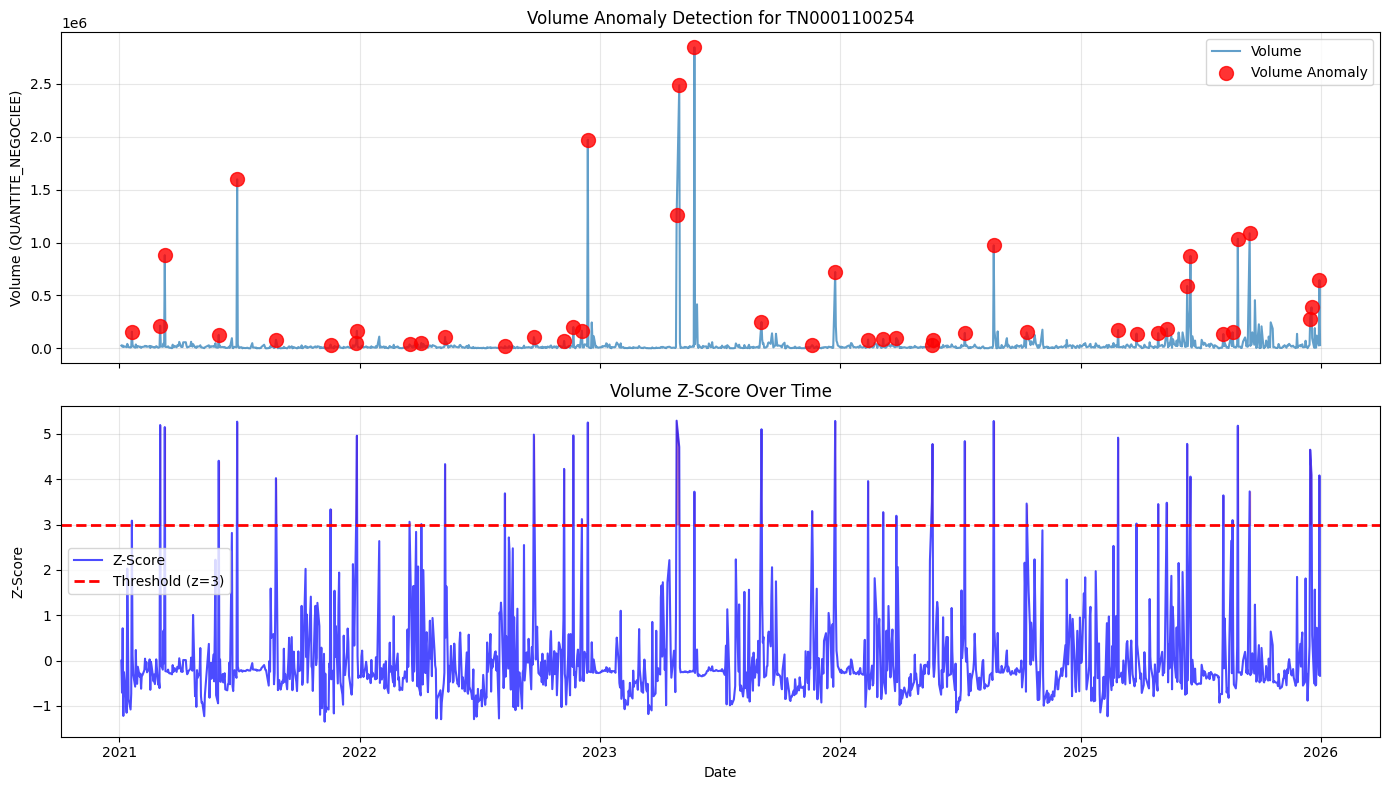


Volume Anomalys for TN0001100254: 45


In [22]:
# Visualize volume Anomalys for a specific ticker
import matplotlib.pyplot as plt

ticker_to_plot = dataset['CODE'].iloc[0]  # Change this to any ticker you want
ticker_data = dataset[dataset['CODE'] == ticker_to_plot].sort_values('SEANCE')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot volume with Anomalys highlighted
ax1.plot(ticker_data['SEANCE'], ticker_data['QUANTITE_NEGOCIEE'], label='Volume', alpha=0.7)
Anomalys = ticker_data[ticker_data['VOLUME_Anomaly'] == 1]
ax1.scatter(Anomalys['SEANCE'], Anomalys['QUANTITE_NEGOCIEE'], color='red', s=100, 
            label='Volume Anomaly', zorder=5, alpha=0.8)
ax1.set_ylabel('Volume (QUANTITE_NEGOCIEE)')
ax1.set_title(f'Volume Anomaly Detection for {ticker_to_plot}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot z-score with threshold line
ax2.plot(ticker_data['SEANCE'], ticker_data['volume_z_score'], label='Z-Score', color='blue', alpha=0.7)
ax2.axhline(y=3, color='red', linestyle='--', label='Threshold (z=3)', linewidth=2)
ax2.fill_between(ticker_data['SEANCE'], 3, ticker_data['volume_z_score'], 
                  where=(ticker_data['volume_z_score'] > 3), alpha=0.3, color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Z-Score')
ax2.set_title('Volume Z-Score Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVolume Anomalys for {ticker_to_plot}: {ticker_data['VOLUME_Anomaly'].sum()}")

## Variation anomaly detection

In [9]:
def detect_variation_anomalies(df, window, threshold):
    df = df.copy()
    df = df.sort_values(['CODE', 'SEANCE'])
    
    # Calculate rolling mean and std for each ticker
    df['rolling_mean_var'] = df.groupby('CODE')['VARIATION'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df['rolling_std_var'] = df.groupby('CODE')['VARIATION'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    
    # Calculate z-score
    # Handle division by zero (when std = 0)
    df['variation_z_score'] = np.where(
        df['rolling_std_var'] > 0,
        (df['VARIATION'] - df['rolling_mean_var']) / df['rolling_std_var'],
        0
    )
    
    # Detect anomalies (absolute z-score > threshold)
    # Unlike volume (which is usually a Anomaly), variation anomalies can be positive or negative shocks
    df['VARIATION_ANOMALY'] = (np.abs(df['variation_z_score']) > threshold).astype(int)
    
    # Drop temporary columns
    df = df.drop(['rolling_mean_var', 'rolling_std_var'], axis=1)
    
    return df

In [17]:
# Apply variation anomaly detection
print("Detecting variation anomalies...")
# Using a window of 30 days for variation to capture anomalies relative to recent volatility, 
# and a threshold of 3 standard deviations.
dataset = detect_variation_anomalies(dataset, window=1275, threshold=3)

# Display summary statistics
print(f"\nTotal records: {len(dataset)}")
print(f"Variation anomalies detected: {dataset['VARIATION_ANOMALY'].sum()}")
print(f"Percentage of variation anomalies: {dataset['VARIATION_ANOMALY'].mean() * 100:.2f}%")
print(f"\nVariation Z-score statistics:")
print(dataset['variation_z_score'].describe())

Detecting variation anomalies...

Total records: 18840
Variation anomalies detected: 329
Percentage of variation anomalies: 1.75%

Variation Z-score statistics:
count    18840.000000
mean         0.014588
std          0.969399
min        -14.086291
25%         -0.386496
50%         -0.013640
75%          0.352976
max          6.902686
Name: variation_z_score, dtype: float64


In [18]:
# View samples of detected variation anomalies
variation_anomalies = dataset[dataset['VARIATION_ANOMALY'] == 1].sort_values('variation_z_score', key=abs, ascending=False)
print("\nTop 10 variation anomalies by absolute z-score:")
print(variation_anomalies[['SEANCE', 'CODE', 'VALEUR', 'VARIATION', 'variation_z_score', 'VARIATION_ANOMALY']].head(10))


Top 10 variation anomalies by absolute z-score:
          SEANCE          CODE            VALEUR  VARIATION  \
15482 2022-08-22  TN0007610017               SAH -19.275930   
12777 2021-11-18  TN0007530017  ONE TECH HOLDING -32.116788   
4105  2022-05-10  TN0002200053                BT -18.416801   
2344  2025-04-30  TN0001600154     ATTIJARI BANK -13.167260   
9185  2022-07-28  TN0006560015           SOTUVER -11.827957   
2596  2021-05-04  TN0001800457              BIAT -46.960736   
7400  2025-06-17  TN0003100609               BNA -11.111111   
1580  2022-04-19  TN0001600154     ATTIJARI BANK -10.433526   
7161  2024-07-02  TN0003100609               BNA -10.233593   
489   2022-12-09  TN0001100254              SFBT   5.945122   

       variation_z_score  VARIATION_ANOMALY  
15482         -14.086291                  1  
12777         -13.304015                  1  
4105          -13.043544                  1  
2344           -9.717663                  1  
9185           -9.407173   

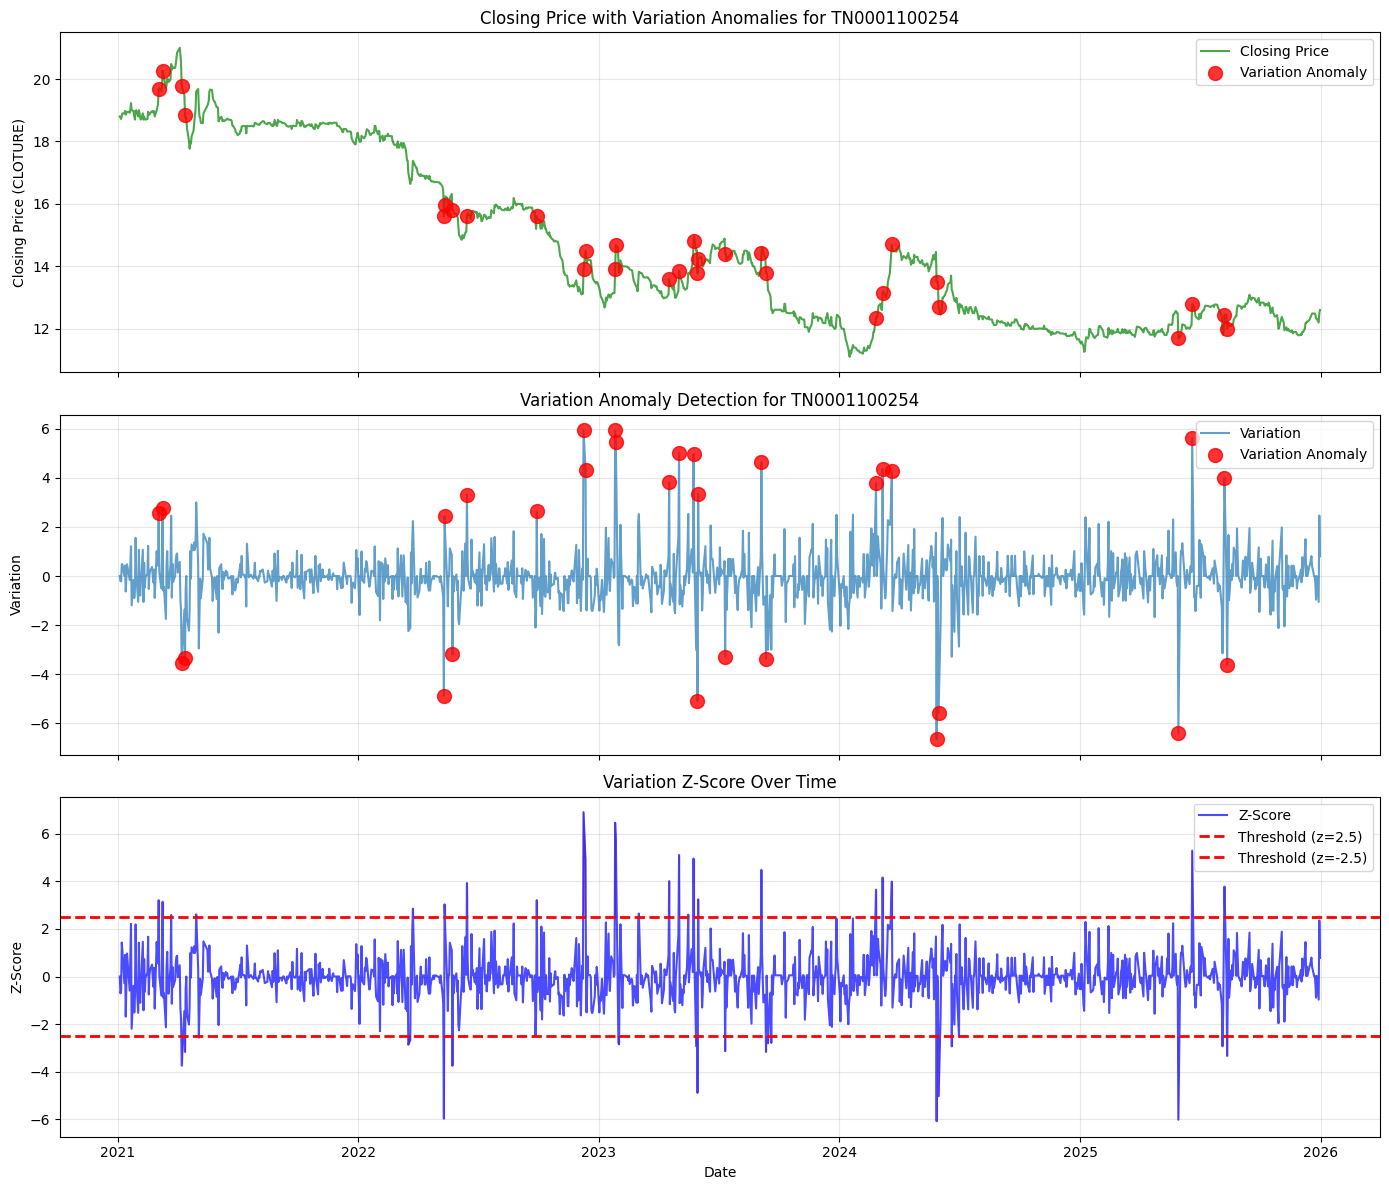


Variation anomalies for TN0001100254: 30


In [19]:
# Visualize variation anomalies for a specific ticker
ticker_to_plot = dataset['CODE'].iloc[5]  # Change this to any ticker you want
ticker_data = dataset[dataset['CODE'] == ticker_to_plot].sort_values('SEANCE')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot closing price with anomalies highlighted
ax1.plot(ticker_data['SEANCE'], ticker_data['CLOTURE'], label='Closing Price', alpha=0.7, color='green')
anomalies = ticker_data[ticker_data['VARIATION_ANOMALY'] == 1]
ax1.scatter(anomalies['SEANCE'], anomalies['CLOTURE'], color='red', s=100, 
            label='Variation Anomaly', zorder=5, alpha=0.8)
ax1.set_ylabel('Closing Price (CLOTURE)')
ax1.set_title(f'Closing Price with Variation Anomalies for {ticker_to_plot}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot variation with anomalies highlighted
ax2.plot(ticker_data['SEANCE'], ticker_data['VARIATION'], label='Variation', alpha=0.7)
ax2.scatter(anomalies['SEANCE'], anomalies['VARIATION'], color='red', s=100, 
            label='Variation Anomaly', zorder=5, alpha=0.8)
ax2.set_ylabel('Variation')
ax2.set_title(f'Variation Anomaly Detection for {ticker_to_plot}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot z-score with threshold lines
ax3.plot(ticker_data['SEANCE'], ticker_data['variation_z_score'], label='Z-Score', color='blue', alpha=0.7)
ax3.axhline(y=2.5, color='red', linestyle='--', label='Threshold (z=2.5)', linewidth=2)
ax3.axhline(y=-2.5, color='red', linestyle='--', label='Threshold (z=-2.5)', linewidth=2)
ax3.fill_between(ticker_data['SEANCE'], 2.5, ticker_data['variation_z_score'], 
                  where=(ticker_data['variation_z_score'] > 2.5), alpha=0.3, color='red')
ax3.fill_between(ticker_data['SEANCE'], -2.5, ticker_data['variation_z_score'], 
                  where=(ticker_data['variation_z_score'] < -2.5), alpha=0.3, color='red')
ax3.set_xlabel('Date')
ax3.set_ylabel('Z-Score')
ax3.set_title('Variation Z-Score Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVariation anomalies for {ticker_to_plot}: {ticker_data['VARIATION_ANOMALY'].sum()}")

## Linking anomalies to news

In [58]:
def link_anomalies_to_news(df, news_window=3):
    df = df.copy()
    df = df.sort_values(['CODE', 'SEANCE'])
    
    # 1. Identify News Events
    # We consider news significant if Article_Count > 0
    # We also determine the sentiment direction of the news
    df['has_news'] = (df['Article_Count'] > 0).astype(int)
    df['news_pos'] = ((df['Article_Count'] > 0) & (df['Mean_Weighted_Sentiment'] > 0)).astype(int)
    df['news_neg'] = ((df['Article_Count'] > 0) & (df['Mean_Weighted_Sentiment'] < 0)).astype(int)
    
    # 2. Pre-calculate Rolling Existence of News (Prior and Future)
    # dependent on the window size.
    # Shift(1) looks at [t-window, t-1] relative to t.
    
    # Prior News (for Post-News Analysis)
    grouped = df.groupby('CODE')
    df['prior_any_news'] = grouped['has_news'].transform(lambda x: x.rolling(window=news_window, min_periods=1).sum().shift(1).fillna(0)) > 0
    df['prior_pos_news'] = grouped['news_pos'].transform(lambda x: x.rolling(window=news_window, min_periods=1).sum().shift(1).fillna(0)) > 0
    df['prior_neg_news'] = grouped['news_neg'].transform(lambda x: x.rolling(window=news_window, min_periods=1).sum().shift(1).fillna(0)) > 0
    
    # Future News (for Pre-News/Leakage Analysis)
    # Reverse, roll, shift, reverse back
    def get_future_rolling(series, w):
        return series.iloc[::-1].rolling(window=w, min_periods=1).sum().shift(1).iloc[::-1].fillna(0) > 0

    df['future_any_news'] = grouped['has_news'].transform(lambda x: get_future_rolling(x, news_window))
    df['future_pos_news'] = grouped['news_pos'].transform(lambda x: get_future_rolling(x, news_window))
    df['future_neg_news'] = grouped['news_neg'].transform(lambda x: get_future_rolling(x, news_window))
    
    # 3. Calculate Binary Columns
    
    # -- VARIATION ANOMALIES --
    df['VARIATION_ANOMALY_POST_NEWS'] = 0
    df['VARIATION_ANOMALY_PRE_NEWS'] = 0
    
    # Post-News: Anomaly matches prior news direction
    # Positive Shock (Up) & Prior Positive News
    cond_var_post_pos = (df['VARIATION_ANOMALY'] == 1) & (df['variation_z_score'] > 0) & df['prior_pos_news']
    # Negative Shock (Down) & Prior Negative News
    cond_var_post_neg = (df['VARIATION_ANOMALY'] == 1) & (df['variation_z_score'] < 0) & df['prior_neg_news']
    
    df.loc[cond_var_post_pos | cond_var_post_neg, 'VARIATION_ANOMALY_POST_NEWS'] = 1
    
    # Pre-News: Anomaly matches future news direction (and NOT post-news)
    # Only if POST is 0
    not_post_var = (df['VARIATION_ANOMALY'] == 1) & (df['VARIATION_ANOMALY_POST_NEWS'] == 0)
    
    cond_var_pre_pos = not_post_var & (df['variation_z_score'] > 0) & df['future_pos_news']
    cond_var_pre_neg = not_post_var & (df['variation_z_score'] < 0) & df['future_neg_news']
    
    df.loc[cond_var_pre_pos | cond_var_pre_neg, 'VARIATION_ANOMALY_PRE_NEWS'] = 1
    
    
    # -- VOLUME ANOMALIES --
    # Volume is directionless (high magnitude). Any news explains it.
    df['VOLUME_ANOMALY_POST_NEWS'] = 0
    df['VOLUME_ANOMALY_PRE_NEWS'] = 0
    
    # Post-News: Any prior news
    cond_vol_post = (df['VOLUME_Anomaly'] == 1) & df['prior_any_news']
    df.loc[cond_vol_post, 'VOLUME_ANOMALY_POST_NEWS'] = 1
    
    # Pre-News: Any future news (and NOT post-news)
    not_post_vol = (df['VOLUME_Anomaly'] == 1) & (df['VOLUME_ANOMALY_POST_NEWS'] == 0)
    cond_vol_pre = not_post_vol & df['future_any_news']
    df.loc[cond_vol_pre, 'VOLUME_ANOMALY_PRE_NEWS'] = 1
    
    # Cleanup
    df = df.drop(columns=['has_news', 'news_pos', 'news_neg', 
                          'prior_any_news', 'prior_pos_news', 'prior_neg_news',
                          'future_any_news', 'future_pos_news', 'future_neg_news'])
    
    return df

# Apply the linking logic
print("Linking anomalies to news context...")
dataset = link_anomalies_to_news(dataset, news_window=3)

# Display stats
cols = ['VARIATION_ANOMALY_POST_NEWS', 'VARIATION_ANOMALY_PRE_NEWS', 
        'VOLUME_ANOMALY_POST_NEWS', 'VOLUME_ANOMALY_PRE_NEWS']
print("\nAnomaly - News Link Statistics:")
print(dataset[cols].sum())
print("\nPercentage of Total Records:")
print(dataset[cols].mean() * 100)

Linking anomalies to news context...

Anomaly - News Link Statistics:
VARIATION_ANOMALY_POST_NEWS     97
VARIATION_ANOMALY_PRE_NEWS      48
VOLUME_ANOMALY_POST_NEWS       282
VOLUME_ANOMALY_PRE_NEWS        128
dtype: int64

Percentage of Total Records:
VARIATION_ANOMALY_POST_NEWS    0.514862
VARIATION_ANOMALY_PRE_NEWS     0.254777
VOLUME_ANOMALY_POST_NEWS       1.496815
VOLUME_ANOMALY_PRE_NEWS        0.679406
dtype: float64


In [59]:
# Inspect some examples of Reaction vs Leakage

print("\n--- Example: Variation Anomaly (Reaction to News) ---")
post_news_examples = dataset[dataset['VARIATION_ANOMALY_POST_NEWS'] == 1].head(3)
print(post_news_examples[['SEANCE', 'CODE', 'variation_z_score', 'VARIATION_ANOMALY_POST_NEWS']])

print("\n--- Example: Variation Anomaly (Possible Leakage / Pre-News) ---")
pre_news_examples = dataset[dataset['VARIATION_ANOMALY_PRE_NEWS'] == 1].head(3)
print(pre_news_examples[['SEANCE', 'CODE', 'variation_z_score', 'VARIATION_ANOMALY_PRE_NEWS']])



--- Example: Variation Anomaly (Reaction to News) ---
        SEANCE          CODE  variation_z_score  VARIATION_ANOMALY_POST_NEWS
67  2021-04-08  TN0001100254          -3.742108                            1
69  2021-04-13  TN0001100254          -3.168913                            1
580 2023-04-18  TN0001100254           4.006663                            1

--- Example: Variation Anomaly (Possible Leakage / Pre-News) ---
        SEANCE          CODE  variation_z_score  VARIATION_ANOMALY_PRE_NEWS
46  2021-03-10  TN0001100254           3.140997                           1
339 2022-05-12  TN0001100254           3.030837                           1
610 2023-06-01  TN0001100254           3.241561                           1


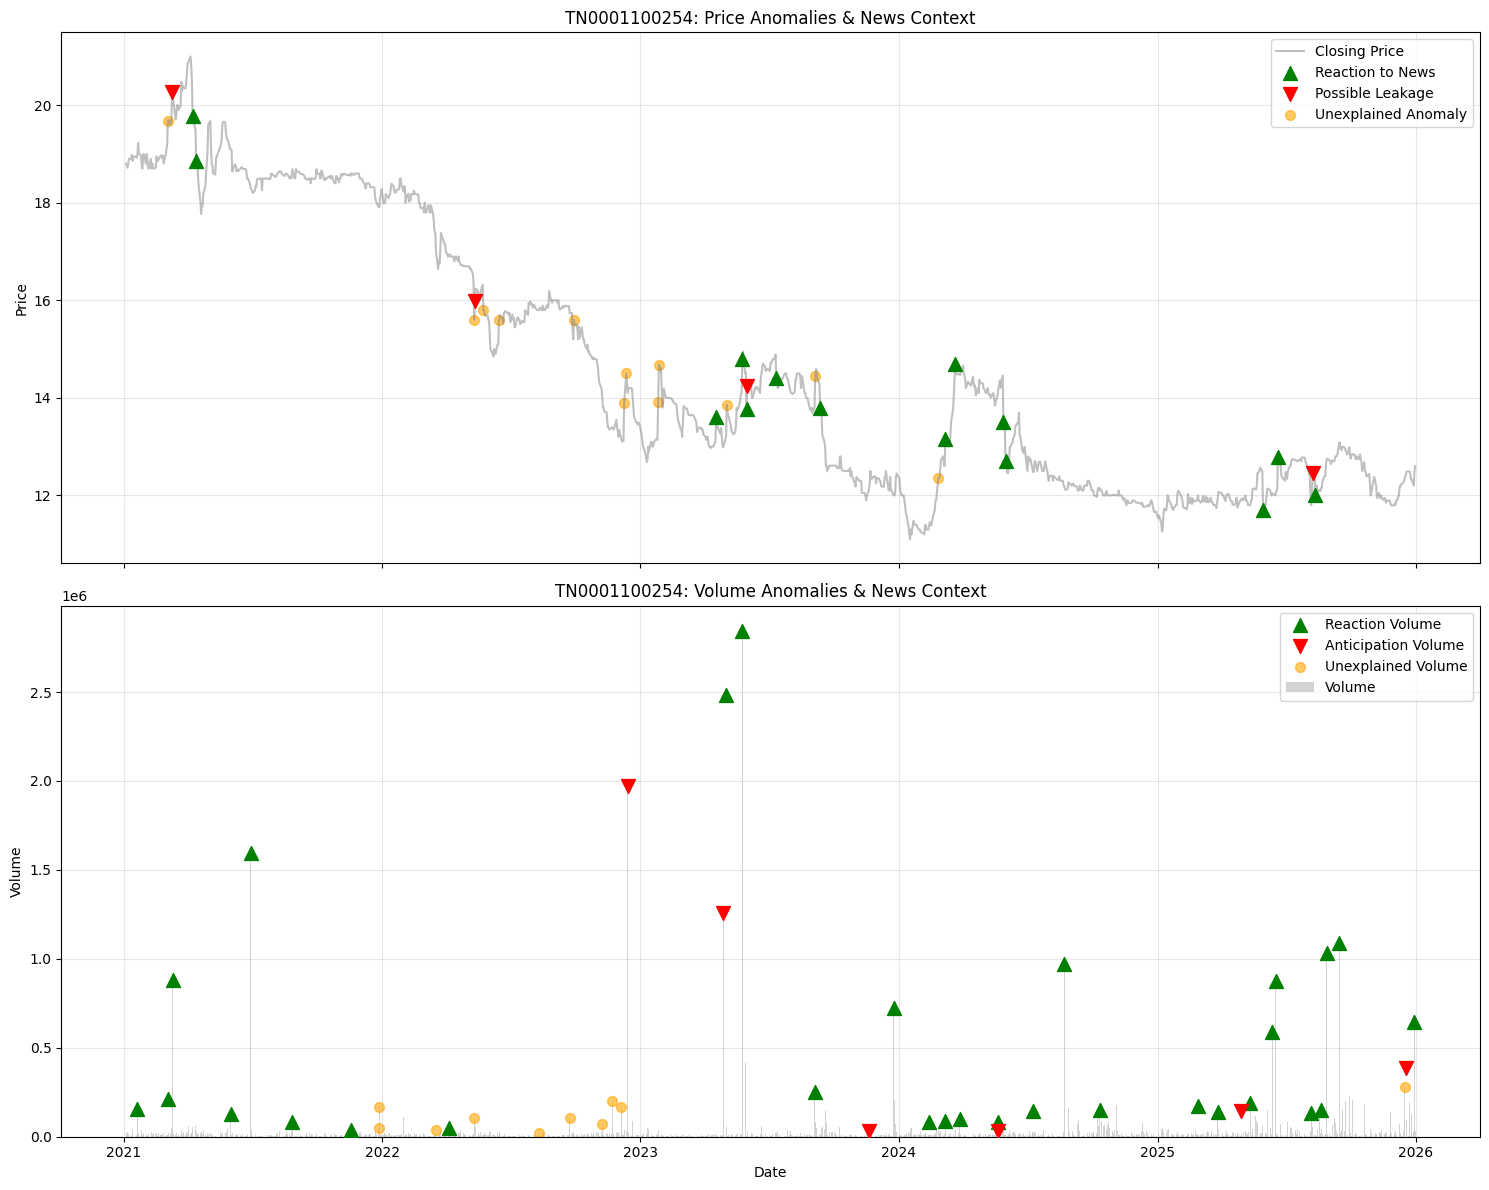

In [61]:
# Visualize Linked Anomalies
ticker_plot = dataset['CODE'].iloc[5] # Example ticker
ticker_data = dataset[dataset['CODE'] == ticker_plot].sort_values('SEANCE')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# 1. Price Plot (Variation Anomalies)
ax1.plot(ticker_data['SEANCE'], ticker_data['CLOTURE'], label='Closing Price', color='gray', alpha=0.5)

# Highlight Post-News Variation Anomalies (Reactions) - Green
mask_var_post = (ticker_data['VARIATION_ANOMALY_POST_NEWS'] == 1)
ax1.scatter(ticker_data[mask_var_post]['SEANCE'], ticker_data[mask_var_post]['CLOTURE'], 
            color='green', s=100, label='Reaction to News', marker='^', zorder=5)

# Highlight Pre-News Variation Anomalies (Leakage?) - Red
mask_var_pre = (ticker_data['VARIATION_ANOMALY_PRE_NEWS'] == 1)
ax1.scatter(ticker_data[mask_var_pre]['SEANCE'], ticker_data[mask_var_pre]['CLOTURE'], 
            color='red', s=100, label='Possible Leakage', marker='v', zorder=5)

# Highlight Other Anomalies - Orange
mask_var_other = (ticker_data['VARIATION_ANOMALY'] == 1) & (ticker_data['VARIATION_ANOMALY_POST_NEWS'] == 0) & (ticker_data['VARIATION_ANOMALY_PRE_NEWS'] == 0)
ax1.scatter(ticker_data[mask_var_other]['SEANCE'], ticker_data[mask_var_other]['CLOTURE'], 
            color='orange', s=50, label='Unexplained Anomaly', marker='o', alpha=0.6)

ax1.set_title(f'{ticker_plot}: Price Anomalies & News Context')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Volume Plot (Volume Anomalies)
ax2.bar(ticker_data['SEANCE'], ticker_data['QUANTITE_NEGOCIEE'], label='Volume', color='lightgray', width=1)

# Highlight Post-News Volume Anomalies - Green
mask_vol_post = (ticker_data['VOLUME_ANOMALY_POST_NEWS'] == 1)
ax2.scatter(ticker_data[mask_vol_post]['SEANCE'], ticker_data[mask_vol_post]['QUANTITE_NEGOCIEE'], 
            color='green', s=100, label='Reaction Volume', marker='^', zorder=5)

# Highlight Pre-News Volume Anomalies - Red
mask_vol_pre = (ticker_data['VOLUME_ANOMALY_PRE_NEWS'] == 1)
ax2.scatter(ticker_data[mask_vol_pre]['SEANCE'], ticker_data[mask_vol_pre]['QUANTITE_NEGOCIEE'], 
            color='red', s=100, label='Anticipation Volume', marker='v', zorder=5)

# Highlight Other Volume Anomalies - Orange
mask_vol_other = (ticker_data['VOLUME_Anomaly'] == 1) & (ticker_data['VOLUME_ANOMALY_POST_NEWS'] == 0) & (ticker_data['VOLUME_ANOMALY_PRE_NEWS'] == 0)
ax2.scatter(ticker_data[mask_vol_other]['SEANCE'], ticker_data[mask_vol_other]['QUANTITE_NEGOCIEE'], 
            color='orange', s=50, label='Unexplained Volume', marker='o', alpha=0.6)

ax2.set_title(f'{ticker_plot}: Volume Anomalies & News Context')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [62]:
# Detailed Statistics
def print_detailed_stats(df, anomaly_type):
    base_col = f'{anomaly_type}_ANOMALY' if anomaly_type == 'VARIATION' else 'VOLUME_Anomaly'
    post_col = f'{anomaly_type}_ANOMALY_POST_NEWS'
    pre_col = f'{anomaly_type}_ANOMALY_PRE_NEWS'
    
    total_anomalies = df[base_col].sum()
    post_count = df[post_col].sum()
    pre_count = df[pre_col].sum()
    unexplained = total_anomalies - post_count - pre_count
    
    print(f"\n--- {anomaly_type} Anomaly Statistics ---")
    print(f"Total Anomalies: {total_anomalies}")
    print(f"  - Explained by PRIOR News (Reaction): {post_count} ({post_count/total_anomalies*100:.1f}%)")
    print(f"  - Preceding FUTURE News (Possible Leakage): {pre_count} ({pre_count/total_anomalies*100:.1f}%)")
    print(f"  - Unexplained (No nearby news): {unexplained} ({unexplained/total_anomalies*100:.1f}%)")

print_detailed_stats(dataset, 'VARIATION')
print_detailed_stats(dataset, 'VOLUME')

# Cross-tabulation to see overlaps
print("\n--- Overlaps between Volume and Variation Anomalies ---")
crosstab = pd.crosstab(dataset['VARIATION_ANOMALY'], dataset['VOLUME_Anomaly'])
crosstab.index = ['No Var Anomaly', 'Var Anomaly']
crosstab.columns = ['No Vol Anomaly', 'Vol Anomaly']
print(crosstab)


--- VARIATION Anomaly Statistics ---
Total Anomalies: 329
  - Explained by PRIOR News (Reaction): 97 (29.5%)
  - Preceding FUTURE News (Possible Leakage): 48 (14.6%)
  - Unexplained (No nearby news): 184 (55.9%)

--- VOLUME Anomaly Statistics ---
Total Anomalies: 600
  - Explained by PRIOR News (Reaction): 282 (47.0%)
  - Preceding FUTURE News (Possible Leakage): 128 (21.3%)
  - Unexplained (No nearby news): 190 (31.7%)

--- Overlaps between Volume and Variation Anomalies ---
                No Vol Anomaly  Vol Anomaly
No Var Anomaly           17967          544
Var Anomaly                273           56


In [63]:
dataset.to_csv('../data/historical_data.csv', index=False)

## Saving anomaly calculation parameters

In [8]:
def fit_anomaly_detectors(historical_df: pd.DataFrame, volume_window=30, volume_threshold=3, 
                          variation_window=1275, variation_threshold=3) -> dict:
    """
    Fit anomaly detection parameters on historical data.
    
    Args:
        historical_df: Historical market data
        volume_window: Rolling window for volume anomaly detection
        volume_threshold: Z-score threshold for volume anomalies
        variation_window: Rolling window for variation anomaly detection
        variation_threshold: Z-score threshold for variation anomalies
    
    Returns:
        dict: Dictionary containing fitted parameters for each CODE
    """
    df = historical_df.copy()
    df = df.sort_values(['CODE', 'SEANCE'])
    
    anomaly_params = {}
    
    for code in df['CODE'].unique():
        code_df = df[df['CODE'] == code].copy()
        
        # Volume parameters (use last value of rolling stats)
        code_df['rolling_mean_vol'] = code_df['QUANTITE_NEGOCIEE'].rolling(
            window=volume_window, min_periods=1
        ).mean()
        code_df['rolling_std_vol'] = code_df['QUANTITE_NEGOCIEE'].rolling(
            window=volume_window, min_periods=1
        ).std()
        
        # Variation parameters (use last value of rolling stats)
        code_df['rolling_mean_var'] = code_df['VARIATION'].rolling(
            window=variation_window, min_periods=1
        ).mean()
        code_df['rolling_std_var'] = code_df['VARIATION'].rolling(
            window=variation_window, min_periods=1
        ).std()
        
        # Store the last known parameters (to be used for future predictions)
        anomaly_params[code] = {
            'volume_mean': code_df['rolling_mean_vol'].iloc[-1],
            'volume_std': code_df['rolling_std_vol'].iloc[-1],
            'variation_mean': code_df['rolling_mean_var'].iloc[-1],
            'variation_std': code_df['rolling_std_var'].iloc[-1],
            'volume_threshold': volume_threshold,
            'variation_threshold': variation_threshold
        }
    
    return anomaly_params

In [10]:
anomaly_params = fit_anomaly_detectors(dataset)

In [12]:
import json

with open('../Forecasting/models/anomaly_params.json', 'w') as f:
    json.dump(anomaly_params, f, indent=2)